# Livrable 1 - Classification binaire



## 1. Chargement des données et constitution du jeu de données

In [2]:
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import time
import pandas as pd
import keras_tuner as kt
import tensorboard
from datetime import datetime
from packaging import version
from tensorflow.keras import regularizers


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Nous commençons par télécharger les images que nous allons utiliser pour faire de la classification d'images. Pour cela, il est nessaire d'ajouter un dossier contenant les différentes catégories d'images au niveau du répertoire racine du projet sous le nom <em>data<em>. 

In [3]:
folder = pathlib.Path().resolve()
data_dir = str(folder / "Données")

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [4]:
image_h = 180
image_w = 180
batch_s = 32

Ensuite, nous devons partager le jeu de données en jeu d'entrainement (80% du jeu de données total) et en jeu de test (les 20% restants du jeu de données total).

In [5]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.2,
  subset = "training",
  seed=123,
  image_size=(image_h, image_w),
  batch_size=batch_s)

# Le test_set
test_set = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_h, image_w),
  batch_size=batch_s)

Found 41405 files belonging to 5 classes.
Using 33124 files for training.
Found 41405 files belonging to 5 classes.
Using 8281 files for validation.


Le sortie précise qu'on a 41405 fichiers au complet dont 33124 appartenant au jeu d'entrainement et 8281 au jeu de test. Maintenant le jeu de données est prêt. Nous allons ensuite visualiser ces données.

## 2. Exploration et visualisation des données

Commençons, tout d'abord par afficher le nom des classes. Elles doivent correspondre aux différents types d'images (Photo, Peinture, Texte, ...)

In [6]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


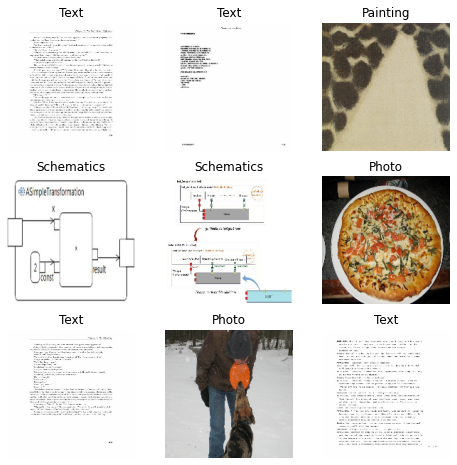

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Indication sur la taille des images :

In [8]:
print(type(train_set))
images, labels =  next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(32, 180, 180, 3)
(32,)


Nous allons configurer les données pour améliorer les performances d'exécution

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Création de notre modèle

Création de notre modèle avec Dropout :

In [10]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = tf.keras.Sequential([
  # Normalisation
  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
  tf.keras.layers.Dense(num_classes, activation = "softmax")
])

Compilation du modèle et configuration de points de sauvegarde (pour éviter de relancer l'entrainement du modèle) : 

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [14]:
model.build((None, 180, 180, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

In [15]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

Lancement de l'entrainement du modèle :

In [16]:
epochs = 3

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

history = model.fit(
  train_set,
  callbacks=[cp_callback, tensorboard_callback],
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/3
1036/1036 [==============================] - ETA: 0s - loss: 1.0606 - accuracy: 0.5173
Epoch 00001: saving model to training\cp-0001.ckpt
1036/1036 [==============================] - 417s 402ms/step - loss: 1.0606 - accuracy: 0.5173 - val_loss: 0.6740 - val_accuracy: 0.6668
Epoch 2/3
1036/1036 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6913
Epoch 00002: saving model to training\cp-0002.ckpt
1036/1036 [==============================] - 396s 382ms/step - loss: 0.5931 - accuracy: 0.6913 - val_loss: 0.5655 - val_accuracy: 0.7561
Epoch 3/3
1036/1036 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.7637
Epoch 00003: saving model to training\cp-0003.ckpt
1036/1036 [==============================] - 398s 384ms/step - loss: 0.5018 - accuracy: 0.7637 - val_loss: 0.5155 - val_accuracy: 0.7881


Récupération des poids préalablement sauvegardés du modèle :

<font color='red'>Exécuter que si le fit n'a pas été exécuté.</font>

In [ ]:
# A run qu'en cas de non run du fit /!\
latest = tf.train.latest_checkpoint(checkpoint_dir)
# # Load the previously saved weights
model.load_weights(latest)

## 4. Faire des prédictions

On donne notre set de test à notre modèle afin qu'il fasse des prédictions.

In [17]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_set, verbose=1) # verbose shows us how long there is to go

259/259 [==============================] - 18s 66ms/step


In [18]:
unique_labels = np.unique(class_names)

# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_labels))
preds_df.head()

test_predictions = model.predict(test_set, verbose=1)

preds_df[list(unique_labels)] = test_predictions
preds_df.head()

259/259 [==============================] - 18s 68ms/step


,id,Painting,Photo,Schematics,Sketch,Text
0,NaN,8.110939e-09,1.317031e-11,0.000050,0.000026,9.999241e-01
1,NaN,2.335407e-01,4.860634e-01,0.279120,0.001179,9.763527e-05
2,NaN,6.525642e-01,3.289376e-01,0.017937,0.000561,1.465092e-11
3,NaN,1.158408e-04,2.519738e-06,0.031959,0.002888,9.650347e-01
4,NaN,2.493672e-01,5.235447e-01,0.226892,0.000190,5.998964e-06


In [19]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """

  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])

In [20]:
def get_pred_labels(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  labels=[]
    
  for item in prediction_probabilities:
    labels.append(np.argmax(item))
  #return unique_labels[np.argmax(prediction_probabilities)]
  return labels

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_labels(predictions)

In [21]:
images_ = []
labels_ = []

# Loop through unbatched data

for image, label in test_set.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [22]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    #labels.append(unique_labels[label])
    labels.append(label)

  return images,labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(test_set)
val_images[0], val_labels[0]

(array([[[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        ...,
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],
 
        [[254., 254., 254.],
 

In [23]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image.astype("uint8"))
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

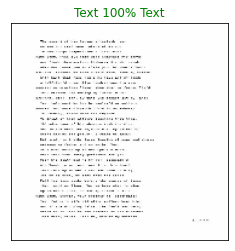

In [24]:
plot_pred(prediction_probabilities=predictions,
          labels=unique_labels[val_labels],
          images=val_images,
          n=17)

In [25]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-5:][::-1]
  # Find the top 10 prediction confidence value
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

Nous affichons ici des images avec le label prédit, le pourcentage de la prédiction et le label prédit.

<function matplotlib.pyplot.show(close=None, block=None)>

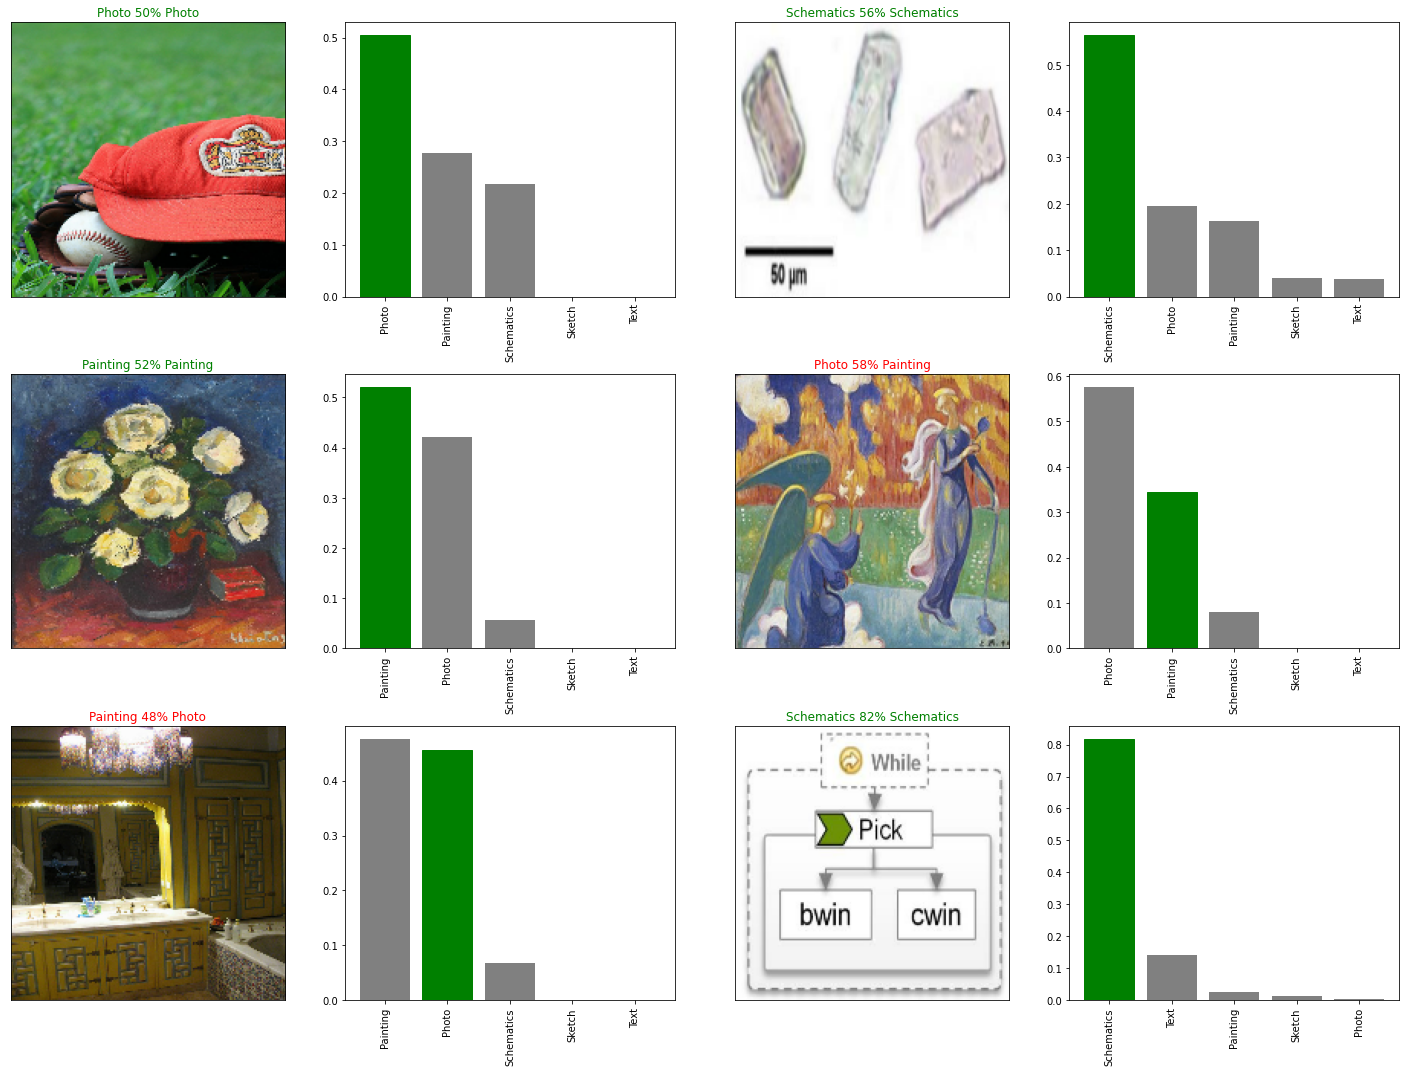

In [26]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=unique_labels[val_labels],
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=unique_labels[val_labels],
                 n=i+i_multiplier)
plt.tight_layout()
plt.show

On affiche ci-dessous la précision et la perte de notre jeu d'entrainement et de notre jeu de validation.

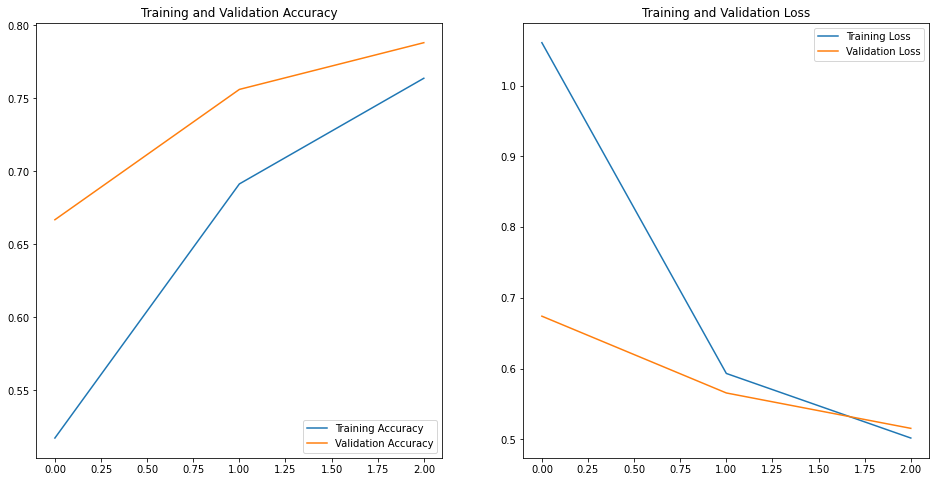

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

On observe que la courbe de performance augmente au cours des "epochs". La précision du jeu de test atteint une valeur relativement proche de celle du jeu d'entrainement. Et la perte du jeu d'entrainement et du jeu de test baisse continuellement. 

## 5. Mesures de performance


In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score

### Matrice de confusion

La matrice de confusion est un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle.

In [29]:
pred_label = get_pred_labels(predictions)

results = confusion_matrix(val_labels, pred_label)
print ('Confusion Matrix :')
print(results)
print ('Accuracy Score is',accuracy_score(val_labels, pred_label))
print ('Classification Report : ')
print (classification_report(val_labels, pred_label))

Confusion Matrix :
[[1121  705  197    6    2]
 [ 425 1565   56    3    0]
 [  16  239 1620    8   71]
 [   0    0   18  269    0]
 [   0    0    9    0 1951]]
Accuracy Score is 0.7880690737833596
Classification Report : 
              precision    recall  f1-score   support

           0       0.72      0.55      0.62      2031
           1       0.62      0.76      0.69      2049
           2       0.85      0.83      0.84      1954
           3       0.94      0.94      0.94       287
           4       0.96      1.00      0.98      1960

    accuracy                           0.79      8281
   macro avg       0.82      0.82      0.81      8281
weighted avg       0.79      0.79      0.79      8281



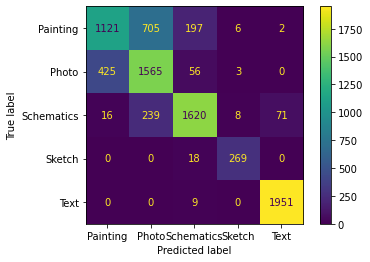

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix= results, display_labels= unique_labels)
disp.plot()
plt.show()

On peut conclure via la matrice de confusion que les peintures sont souvent confondues avec les photos (1075 sont considérées comme des photos sur un total de 3 234 peintures). 

### Autres mesures de performance

Nous allons faire des mesures sur la performance du modèle.

Le score F1 peut être interprété comme une moyenne harmonique de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et le pire score à 0. La contribution relative de la précision et du rappel au score F1 est égale. La formule du score F1 est : 

$$ F1 =  \frac{2 * (precision * recall)}{(precision + recall)}  $$

In [31]:
print ('Calculez les métriques pour chaque étiquette et trouvez leur moyenne non pondérée. Cela ne prend pas en compte le déséquilibre des étiquettes.')
print ('F1 Score Macro =', f1_score(val_labels, pred_label, average='macro'))

Calculez les métriques pour chaque étiquette et trouvez leur moyenne non pondérée. Cela ne prend pas en compte le déséquilibre des étiquettes.
F1 Score Macro = 0.8139432875359599


In [32]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 21444), started 18:42:09 ago. (Use '!kill 21444' to kill it.)